# Chance-Constrained Stochastic Trajectory Optimization using SCP

## 1: System Dynamics

Assume we have a system with the state $x = [r,v] \in\mathbb{R}^4$ characterized by the following nonlinear dynamics:

$$ \begin{align} dr &= v dt \\ dv &= (-D + u)dt + \gamma dw \end{align}$$
where $D=\frac{1}{2}C_D\lVert v\rVert ^2\hat{v}$ is a drag force, $\hat{v}=\frac{v}{\lVert v\rVert}$, $u\in\mathbb{R}^n$ is the control, and $\gamma$ is a noise-scale parameter. The noise, $dw$ is assumed to follow standard Brownian motion.

Let's try to setup an optimiztaion framework using convex programming theory.

First, let's write a function to simulate the dynamics of this system

In [149]:
# import packages and load helpers
using CairoMakie # for plotting
using LinearAlgebra # for various linear alebra operations
using Convex # for parsing convex optimization problem 
using Clarabel # algorithm for convex solver
using OrdinaryDiffEq # for integrating ODEs 
using DataInterpolations # for creating interpolating objects (i.e. zero-order hold)
using Random, Distributions # for random distributions 

# pre-written plotting functions
include("helpers.jl")

## Code for dynamics

# nominal dynamics
function double_integrator_dynamics!(x_dot, x, p, t)
    u, cd = p
    
    # Unpack state
    v = x[3:4]
    
    # velocity unit vector
    v_mag = norm(v)
    v_hat = v / v_mag
    
    # drag force
    D = 0.5 * cd * v_mag^2 * v_hat
    
    # dynamics
    x_dot[1:2] .= v
    x_dot[3:4] .= -D + u(t)
end

# perturbed dynamics with feedback control
function double_integrator_feedback_dynamics!(x_dot, x, p, t)
    control, cd, K, noise = p
    
    # Unpack state
    # r_nom = x[1:2]
    v_nom = x[3:4]
    # r = x[5:6]
    v = x[7:8]
    
    # nominal dynamics
    v_mag_nom = norm(v_nom)
    v_hat_nom = v_nom / v_mag_nom
    D_nom = 0.5 * cd * v_mag_nom^2 * v_hat_nom
    u_nom = control(t)

    x_dot[1:2] .= v_nom
    x_dot[3:4] .= -D_nom .+ u_nom

    # perturbed  dynamics
    v_mag = norm(v)
    v_hat = v / v_mag
    
    D = 0.5 * cd * v_mag^2 * v_hat
    u = u_nom + K(t)*(x[5:8] .- x[1:4])
    w = noise(t)
    
    x_dot[5:6] .= v
    x_dot[7:8] .= -D + u + w
end

double_integrator_feedback_dynamics! (generic function with 1 method)

## 2. Optimization Problem

Let's assume we are trying to solve the following optimization problem

$$ 
\begin{aligned} 
\underset{x(t), u(t)}\min J(x, u) \\ 
\mathrm{subject~to}\quad \dot{x} &= f(x)  \\ 
x(t_0) &= x_0 \\ 
x(t_f) &= x_f \\ 
\mathbb{P}(r_1(t)\leq 6) \geq 1-0.9973 
\end{aligned}
$$


where the cost function $J = \int _0^{t_f} \left[\lVert \bar{u}(t) \rVert _2^2 + \mathrm{tr(Cov}(u(t))) \right]\mathrm{d}t$

## 3: Convexification Step 1: Linearization

Recall for a problem to be convex, the cost function and inequality constraints have to be convex functions, and the equality constraints must be affine in the optimization variables. Because the dynamics are nonlinear, the equality constraint for the dynamics above is not convex. Therefore, we must approximate the nonlinear dynamics using a first-order Taylor series expansion about some reference ($\bar{x}(t)$, $\bar{u}(t)$)
$$ dx \approx \left[A(t)(x(t) - \bar{x}(t)) + B(t)(u(t) - \bar{u}(t))\right]dt + G(t)dw  = A(t)x(t) + B(t)u(t) + z(t) + G(t)dw$$
where $z(t) = f(\bar{x}(t), \bar{u}(t)) -A(t)\bar{x}(t) - B(t)\bar{u}(t)$. 

The matrices $A$ and $B$ are the partial derivative of the dyamics $\dot{x}$ with respect to the state $x$ and $control$ u, respectively, evaluated at the reference ($\bar{x}(t)$, $\bar{u}(t)$).
$$ \begin{align} A(t) = \left.\frac{\partial f}{\partial x}\right|_{\mathrm{ref}} \\ B(t) = \left. \frac{\partial f}{\partial u}\right|_{\mathrm{ref}} \end{align}$$

For our system, we can write these Jacobian matrices analytically as
$$ \frac{\partial f}{\partial x} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & \dfrac{\partial \dot{v}_1}{\partial v_1} & \dfrac{\partial \dot{v}_1}{\partial v_2} \\ 0 & 0 & \dfrac{\partial \dot{v}_2}{\partial v_1} & \dfrac{\partial \dot{v}_2}{\partial v_2} \end{bmatrix}$$ 
$$ \frac{\partial f}{\partial u} = \begin{bmatrix}0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1\end{bmatrix} $$

The partial derivatives of the velocity dynamics are written as
$$ \frac{\partial \dot{v}_1}{\partial v_1} = -\frac{1}{2} \frac{C_d \left(2 v_1^2 + v_2^2\right)}{\lVert v \rVert} $$
$$ \frac{\partial \dot{v}_2}{\partial v_2} = -\frac{1}{2} \frac{C_d \left(v_1^2 + 2v_2^2\right)}{\lVert v \rVert} $$
$$ \frac{\partial \dot{v}_1}{\partial v_2} = \frac{\partial \dot{v}_2}{\partial v_1} = -\frac{1}{2}C_d v_1 v_2 $$

In [150]:
## Code for Jacobians

function get_AB(t, x_ref, cd)
    # Unpack
    v = x_ref[3:4]
    v1, v2 = v[1], v[2]
    v_mag = norm(v)
    
    # initialze
    A_lin = zeros(4, 4)
    B_lin = zeros(4, 2)
    
    # Compute partials
    dD1_dv1 = -0.5 * cd * (2 * v1^2 + v2^2) / v_mag
    dD1_dv2 = -0.5 * cd * v1 * v2
    dD2_dv1 = -0.5 * cd * (v1^2 + 2 * v2^2) / v_mag
    dD2_dv2 = -0.5 * cd * v1 * v2
    
    # Fill out A matrix
    A_lin[1, 3] = 1.0
    A_lin[2, 4] = 1.0
    A_lin[3, 3] = dD1_dv1
    A_lin[3, 4] = dD1_dv2
    A_lin[4, 3] = dD2_dv1
    A_lin[4, 4] = dD2_dv2 
    
    # Fill out B matrix
    B_lin[3, 1] = 1.0 
    B_lin[4, 2] = 1.0 
      
    return A_lin, B_lin
end

get_AB (generic function with 1 method)

## Convexification Step 2: Discritization

Next, we need to convert the infinite-dimensional optimal control problem into a finite-dimensional parameter optimization problem. First define a set of $N$ discrete times such that $t_0 < t_1 < \ldots < t_{N-1}$. We then seek to derive the appropriate matrices for the following discrete-time system.
$$ x_{k+1} = A_kx_k + B_ku_k + z_k + G_kw_k$$
where $\bar{x}_k = \bar{x}(t = t_k)$. Here, we have imposed a zero-order hold (ZOH) assumption on the control, which means that $u(t) = u_k ~~\forall t\in[t_k,t_{k+1})$. Because the system dynamics are now approximated as linear using a Taylor series expansion, we may use the state-transition matrix (STM) to express the discrete-time matrices above as
$$ A_k = \Phi(t_{k+1},t_k)$$
$$ B_k = A_k \int _{t_k}^{t_{k+1}} \Phi^{-1}(\tau, t_k)B(\tau)\mathrm{d}\tau$$
$$ z_k = A_k \int _{t_k}^{t_{k+1}} \Phi^{-1}(\tau, t_k)z(\tau)\mathrm{d}\tau$$
$$ G_kG_k^T = A_k \left( \int _{t_k}^{t_{k+1}} \Phi^{-1}(\tau, t_k)G(\tau)G(\tau)^T\Phi^{-T}(\tau, t_k)\mathrm{d}\tau \right)A_k^T$$

Here, $\Phi(t_{k+1}, t_k)$ is the STM from $t=t_k$ to $t=t_{k+1}$ which is computed by integrating the following differential equation
$$ \frac{\mathrm{d}}{\mathrm{d}t}\Phi = A(t)\Phi(t,t_0)\quad \Phi(t_0, t_0)=I$$

The mean dynamics are then expressed as
$$ \bar{x}_{k+1} = A_k\bar{x}_k + B_k\bar{u}_k + z_k$$

The covariance dynamics are expressed as (using the convexification process from class)

$$ P_{k+1} = A_kP_kA_k^T + A_kU_k^TB_k^T + B_kU_kA_k^T + B_kY_kB_k^T + G_kG_k^T $$

To each of these matrices is computed by integrating the following "augmented" state from $t=t_k$ to $t = t_{k+1}$.

$$ \begin{align} X(t) &= \begin{bmatrix} \bar{x}(t) \\ \Phi(t, t_k) \\ B(t) \\ z(t) \\ G(t)G(t)^T \end{bmatrix} & \dot{X} &= \begin{bmatrix} f(\bar{x}(t), \bar{u}(t)) \\ A(t)\Phi(t, t_k) \\ \Phi^{-1}(t, t_0)B(t) \\ \Phi^{-1}(t,t_0)z(t) \\\Phi^{-1}(\tau, t_k)G(\tau)G(\tau)^T\Phi^{-T}(\tau, t_k) \end{bmatrix} & X(t_k) = \begin{bmatrix} \bar{x}(t_k) \\ I \\ 0 \\ 0 \\ 0\end{bmatrix}\end{align} $$

In [151]:
## function for augmented state dynamics

function stm_derivs(x, p, t)
    control, cd, G = p
    # Interpolate reference solution
    x_ref = x[1:4]
    u_ref = control(t)
    
    # Get A, B matrices at reference solution 
    A, B = get_AB(t, x_ref, cd)

    dxdt = zeros(length(x))

    x_ref_dot = zeros(4)
    double_integrator_dynamics!(x_ref_dot, x_ref, (control, cd), t)

    # mean dynamics
    dxdt[1:4] = x_ref_dot

    # STM
    STM = reshape(x[5:20], 4, 4)
    aux = A * STM
    dxdt[5:20] = vec(aux)
    
    # B matrix
    STM_inv = inv(STM)
    aux = STM_inv * B
    dxdt[21:28] = vec(aux)

    # h Vector
    aux = x_ref_dot - A*x_ref - B*u_ref
    dxdt[29:32] = STM_inv*aux

    # G matrix 
    aux = STM_inv*G*G'*STM_inv'
    dxdt[33:48] = vec(aux)
    
    return dxdt
end

## function to compute discsrete matrices at each t_k 
function get_discrete_matrix(t_ref, x_ref, control, cd, G)    
    A = []
    B = []
    z = []
    G_all = []
    STM0 = I(4)
    B0 = zeros(4, 2)
    N = length(t_ref)
    h0 = zeros(4)
    G0 = zeros(4,4)
    for k in 1:N-1
        x0 = vcat(x_ref[:,k], vec(STM0), vec(B0), h0, vec(G0))
        t_span = (t_ref[k], t_ref[k+1])
        prob = ODEProblem(stm_derivs, x0, t_span, (control, cd, G))
        sol = solve(prob, Tsit5(), reltol=1e-12, abstol=1e-12)
        x = sol.u[end]
        
        Ak = reshape(x[5:20], 4, 4)
        Bk = Ak * reshape(x[21:28], 4, 2)
        zk = Ak * x[29:32]
        aux = Ak*reshape(x[33:48], 4, 4)*Ak'
        # @show aux
        Gk = sqrt(aux)

        
        push!(A, Ak)
        push!(B, Bk)
        push!(z, zk)
        push!(G_all, Gk)
    end
    
    return A, B, z, G_all
end


get_discrete_matrix (generic function with 1 method)

## Convex Chance Constraints

The original chance constraint is 
$$ \mathbb{P}[r_1 \leq 6] \geq 1-0.9973$$

The deterministic form of this may be stated as 
$$ a^T\bar{x}_k + \mathrm{cdf}^{-1}(1-0.9973)\sqrt{a^TP_ka} \leq b$$
where $a = [1,0,0,0]$ and $b=6$.

A convex approximation of this is obtained by squaring both sides. Letting $\gamma = \mathrm{cdf}^{-1}(1-0.9973)$

$$ \gamma^2a^TP_ka - (b - a^T\bar{x}_k)^2 \leq 0$$ 
Linearizing the second term around the reference $\hat{x}_k$ yields
$$ \gamma^2a^TP_ka - \left[\left(b-a^T\hat{x}_k\right)^2 - 2a^T\left(b-a^T\hat{x}_k\right)\left(\bar{x}_k-\hat{x}_k\right)\right] \leq 0$$

We will relax this constraint using a slack variable such that 
$$ \gamma^2a^TP_ka - \left[\left(b-a^T\hat{x}_k\right)^2 - 2a^T\left(b-a^T\hat{x}_k\right)\left(\bar{x}_k-\hat{x}_k\right)\right] \leq \tilde{\nu}$$

## Convexification Step 3: Trust Regions and Slack Variables (PTR)

Due to the linearization and discretization, we introduce the issues of artificial unboundedness and artificial infeasibility. To handle artificial unboundedness, we introduce ``trust regions'' which encourage the optimized solution to stay near the reference trajectory such that the linearized dynamics are valid (enough). To this end, we define

$$ \delta x_k = x_k - \bar{x}_k$$
$$ \delta u_k = u_k - \bar{u}_k$$

We now impose the following trust region constraint 
$$ \lVert \delta x_k \rVert _p + \lVert \delta u_k \rVert _p \leq \eta_k $$ 
where $p = \left\{1, 2, 2+, \infty\right\}$ is some norm (here $2+$ denotes the 2-norm squared), and $\eta$ is the trust region radius. Generally, we want to encourage the trust region to be small to drive convergence, so we augment our original cost function with the trust-region radii.
$$ \tilde{J} = J(x,u) + J_{\mathrm{PTR}}(\eta)$$
where $J_{\mathrm{PTR}}$ is a trust-region penalization term.

Next, to handle artificial infeasibility, we introduce a series of slack variables $\nu$ and $\tilde{\nu}$ to relax the dynamics
$$  \bar{x}_{k+1} = A_k \bar{x}_k + B_k \bar{x}_k + z_k + \nu_k $$ 

Again, we discourage these slack variables by adding them to the cost function
$$ \tilde{J} = J(x,u) + J_{\mathrm{PTR}}(\eta) + J_{\mathrm{slack}}(\nu, \tilde{\nu})$$

## Convexification Step 4: Form Convex Subproblem

Now that we have a convex approximation of the original optimal control problem, we can write the 
"subproblem" that will be solved successively.

$$ \begin{align} \underset{x_k, u_k, \eta_k, \nu_k, \tilde{\nu}_k}\min \sum _{k=1}^{N-1} \bar{u}_k^2  + \sum _{k=1}^{N-1}\mathrm{tr}(Y_k) + \lVert \nu\rVert _1 + \lVert \eta_k \rVert _1 + \lVert \tilde{\nu} \rVert _1  \\ \mathrm{subject~to}\quad x_{k+1} &= A_k x_k + B_k u_k + z_k + \nu_k \quad \forall k \\ 
    P_{k+1} &= A_kP_kA_k^T + A_kU_k^TB_k^{T} + B_kU_kA_k^T &+ B_kY_kB_k^T + G_kQ_kG_k^T
\\ \begin{bmatrix}P_k & U_k^T \\ U_k & Y_k\end{bmatrix} &\succeq 0
\\ \bar{x}_{k=0} &= x_0 \\ \bar{x}_{k=N} &= x_f \\ P_{k=0} &= P_0 \\ P_N &\preceq Pf \\ \gamma^2a^TP_ka - \left[\left(b-a^T\hat{x}_k\right)^2 - 2a^T\left(b-a^T\hat{x}_k\right)\left(\bar{x}_k-\hat{x}_k\right)\right] &\leq \tilde{\nu} \\ \lVert \delta x_k \rVert + \lVert \delta u_k \rVert &\leq \eta_k \end{align}$$

Where $a=[1,0,0,0]$ and $b=6$. Let's define this subproblem in $\tt Convex.jl$


In [152]:
## Convex subproblem code
function solve_stoch_problem(x0, xf, P0, Pf, N, x_ref, u_ref, A, B, z, G, Q, r1_max)
    n = length(x0)
    m = length(u_ref[1])
    
    # define variables 
    P = [Semidefinite(n,n) for k = 1:N]
    U = [Variable(m, n) for k = 1:N-1]
    Y = [Semidefinite(m,m) for k = 1:N-1]

    # linear matrix ineq.
    L = [Semidefinite(n+m, n+m) for k = 1:N-1]

    x = Variable(4, N)
    u = Variable(2, N-1)
    ν = Variable(4, N)
    ν̃ = Variable(N)
    η = Variable(N-1)

    # initial/terminal constraints
    constraints = Constraint[x[:,1] - x0 == 0]
    push!(constraints, x[:,end] - xf == 0)
    push!(constraints, P[1] == P0)
    term_cov = Semidefinite(n,n)
    push!(constraints, term_cov == Pf - P[end])

    # perturbation and covariance dynamics
    for k = 1:N-1
        # perturbation
        push!(constraints, x[:,k+1] == A[k]*x[:,k] + B[k]*u[:,k] + z[k] + ν[:,k]) 
        # covariance 
        push!(constraints, P[k+1] == A[k]*P[k]*A[k]' + A[k]*U[k]'*B[k]' + 
                                        B[k]*U[k]*A[k]' + B[k]*Y[k]*B[k]' + G[k]*Q*G[k]' )
        # LMI
        push!(constraints, L[k] == [P[k] U[k]'; U[k] Y[k]])
    end

    # chance constraints 
    Γ = 1 - 0.9973
    γ = Γ/N
    a1 = [1, 0, 0, 0]
    b1 = r1_max
    cdf_term = quantile(Normal(), 1-γ)
    for k = 1:N
        lin_term = (b1 - a1'*x_ref[:,k])^2 - 2*a1'*(b1 - a1'*x_ref[:,k])*(x[:,k] - x_ref[:,k])
        push!(constraints, cdf_term^2*a1'*P[k]*a1 - lin_term <= ν̃[k])
        push!(constraints, b1 - a1'*x[:,k] >= 0)
    end

    # trust regions
    for k = 1:N-1
        push!(constraints, η[k] >= 0)
        push!(constraints, sumsquares(x[:,k] - x_ref[:,k]) + sumsquares(u[:,k] - u_ref[k]) <= η[k])
    end

    # cost function 
    cost_slack = 1e3*norm(ν̃, 1) + 1e3*norm(ν, 1)

    # trace of control covariance
    cost_Y = 0
    for k = 1:N-1
        cost_Y += tr(Y[k])
    end

    # mean control
    cost_u = 0
    for k = 1:N-1
        cost_u += sumsquares(u[:,k])
    end

    # trust regions
    cost_ptr = 1e-3 * norm(η, 1)

    cost = cost_Y + cost_u + cost_ptr + cost_slack
    
    problem = minimize(cost, constraints)

    quiet = true
    solver = Clarabel.Optimizer
    Convex.solve!(problem, solver, silent=quiet)

    K_opt = [evaluate(U[k])*inv(evaluate(P[k])) for k = 1:N-1]
    x_opt = evaluate(x)
    u_opt = [evaluate(u[:,k]) for k = 1:N-1]

    return K_opt, x_opt, u_opt, evaluate(cost_slack)
end


solve_stoch_problem (generic function with 2 methods)

## Successive Solution

Now, we must solve our problem successively. This means that the solution of each subproblem becomes the reference for the next subproblem. Let's write some code to do that 

In [153]:
function scp_iter_stoch(x0, xf, P0, Pf, control, N, cd, t_ref, u_ref, G, Q, r1_max)
    x_ref_all, u_ref_all = [], []
    x_opt, u_opt, K_opt, P = [], [], [], []    
    x_ref = initialize_reference(x0, xf, N)
    total_time = 0
    for n = 1:5
        # get discrete time things
        A, B, z, Gk = get_discrete_matrix(t_ref, x_ref, control, cd, G)

        # solve subproblem 
        loop_time = @elapsed begin
        K_opt, x_opt, u_opt, residual = solve_stoch_problem(x0, xf, P0, Pf, N, x_ref, u_ref, A, B, z, Gk, Q, r1_max)
        end
        total_time += loop_time
        println("ITERATION $n: res = $(residual), elapsed time = $total_time")

        # update reference
        x_ref = x_opt 
        u_ref = u_opt
        control = ConstantInterpolation(u_opt, t_ref[1:N-1], extrapolate=true)
        push!(x_ref_all, x_ref)
        push!(u_ref_all, u_ref)
    end
    return x_ref, control, K_opt, x_ref_all, u_ref_all
end

function initialize_reference(x0, xf, N)
    x_ref = zeros(4, N)
    t = collect(range(0, 1, N))
    for (k, tk) in enumerate(t)
        x_ref[:,k] = (1-tk)*x0 + tk*xf 
    end
    return x_ref 
end

initialize_reference (generic function with 1 method)

Finally, let's write a wrapper to run all of this

In [164]:
# wrapper code 

function run_main()
    x0 = [1, 8, 2, 0]
    xf = [1, 2, -1, 0]
    P0 = 1e-2*I(4)
    Pf = 1e-2*I(4)
    γ = 1e-2
    G = zeros(4,4)
    G[3,3] = G[4,4] = sqrt(γ)
    Q = zeros(4,4)
    Q[3,3] = Q[4,4] = 1

    tf = 15
    cd = 5e-3

    N = 20

    r1_max = 4

    t_ref = collect(range(0, tf, N))
    u_ref = [[0,0] for k = 1:N-1]

    control = ConstantInterpolation(u_ref, t_ref[1:N-1], extrapolate=true)

    run_time = @elapsed begin
    x_opt, control, K, P = scp_iter_stoch(x0, xf, P0, Pf, control, N, cd, t_ref, u_ref, G, Q, r1_max)
    end
    println("Run time = $run_time")

    return (x0, xf, P0, Pf, control, cd, K, x_opt, t_ref, tf, γ, r1_max)
end

run_main (generic function with 1 method)

In [155]:
function run_monte_carlo(x0, xf, P0, Pf, control, cd, K, x_opt, t_ref, tf, γ, r1_max; n_cases=1000)
    x_all = run_and_plot(x0, xf, P0, Pf, control, cd, K, x_opt, t_ref, tf, γ, r1_max; n_cases = n_cases)
    nothing
end

run_monte_carlo (generic function with 3 methods)

In [165]:
## run main code

data = run_main();

ITERATION 1: res = 1.0203936919942205e-10, elapsed time = 0.099333417
ITERATION 2: res = 2.1757105229232392e-11, elapsed time = 0.172686083
ITERATION 3: res = 2.2042878285166086e-11, elapsed time = 0.233650958
ITERATION 4: res = 2.1717475314537606e-11, elapsed time = 0.29546549899999996
ITERATION 5: res = 2.7705277378775174e-11, elapsed time = 0.35678920799999997
Run time = 0.498331542


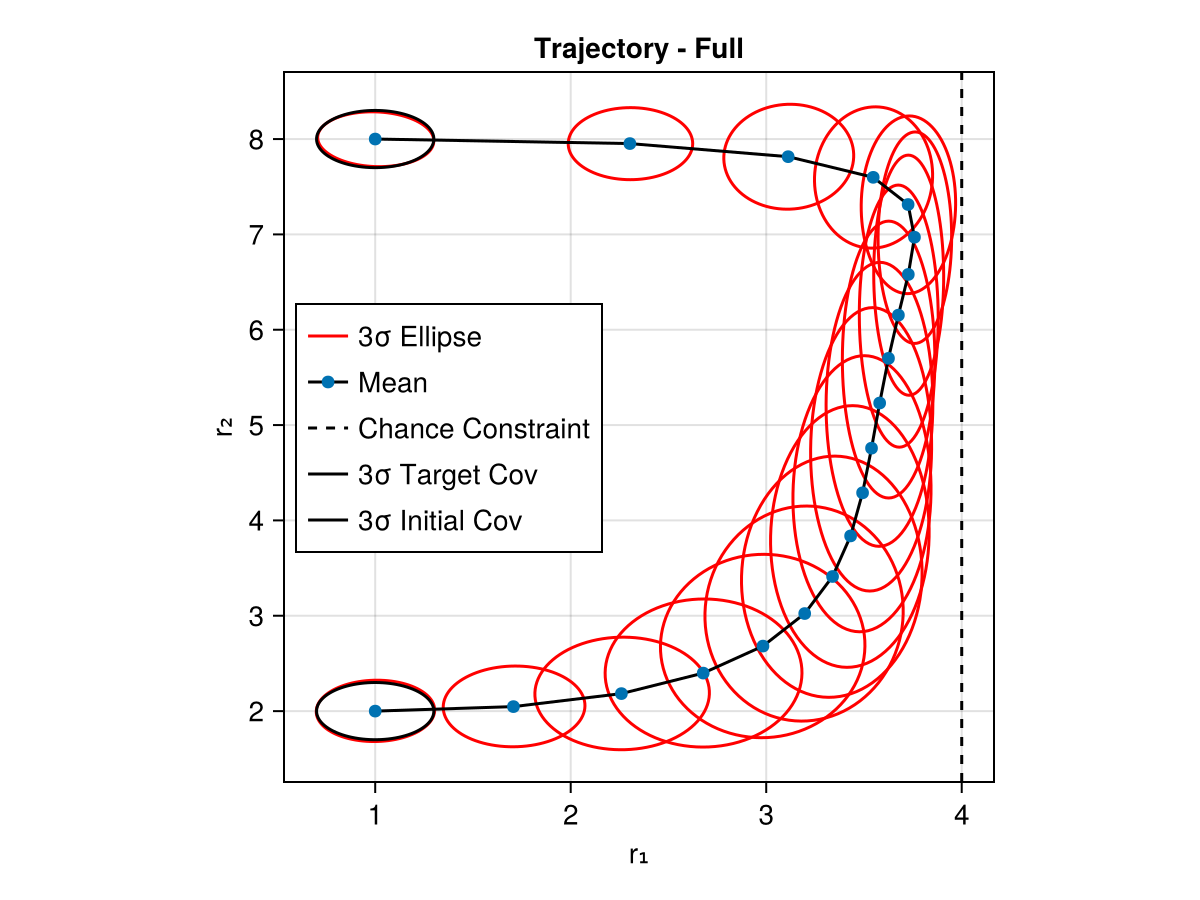

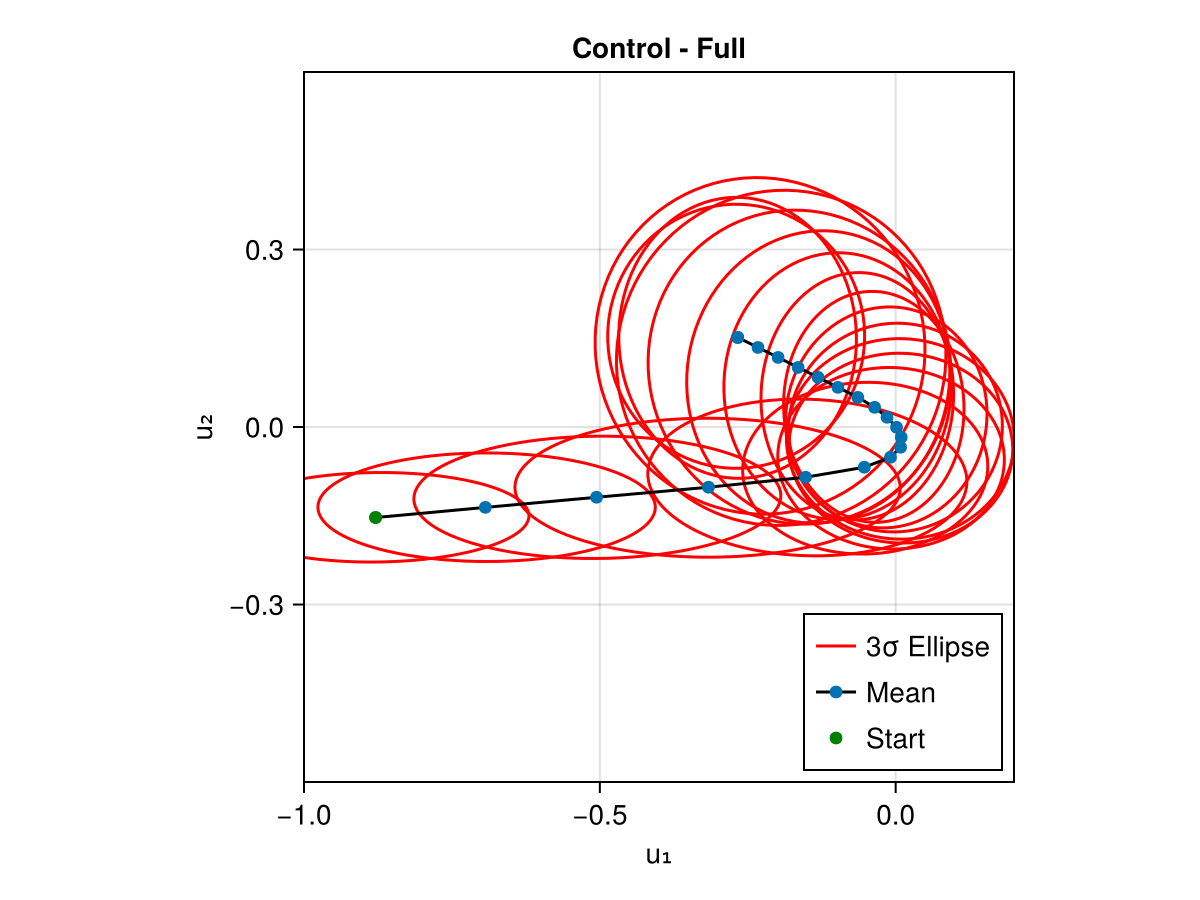

In [166]:
# run Monte Carlo 

# here, the red ellipses are the three-sigma covariance ellipses computed from the nonlinear Monte Carlo analysis.
# They are not the covariance computed in the convex subproblem

run_monte_carlo(data..., n_cases = 1000)